# Lottery Ticket Hypothesis: _Conv-2_ Convolutional Neural Network for CIFAR10 dataset

Implementation of the hypothesis using the following architecture:

1. __Conv layers:__ 64, 64 followed by _Max Pooling_ layer
1. __Dense layer:__ 256, 256, 10

smallest magnitudes in each layer are removed

In [1]:
# %tensorflow_version 2.x

TensorFlow 2.x selected.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
# import tensorflow_model_optimization as tfmot
# from tensorflow_model_optimization.sparsity import keras as sparsity
# from tensorflow.keras import datasets, layers, models

from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal

from sklearn.metrics import accuracy_score, precision_score, recall_score


/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
tf.__version__

'2.0.0'

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [4]:
batch_size = 60
num_classes = 10
num_epochs = 100

In [5]:
# Data preprocessing and cleaning:
# input image dimensions
img_rows, img_cols = 32, 32

# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [6]:
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))

X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 1)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 1)


In [7]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))



'input_shape' which will be used = (32, 32, 3)



In [8]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [9]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [10]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 10)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 10)


### Prepare CIFAR10 dataset for _GradientTape_ training:

In [11]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [12]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [13]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [14]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.0002)

In [15]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [16]:
def conv2_cnn():
	"""
	Function to define the architecture of a neural network model
	following Conv-2 architecture for CIFAR-10 dataset and using
	provided parameter which are used to prune the model.
    
	Conv-2 architecture-
	64, 64, pool  -- convolutions
	256, 256, 10  -- fully connected layers
    
    
	Output: Returns designed and compiled neural network model
	"""
    
	pruned_model = Sequential()
    
	pruned_model.add(
		Conv2D(
			filters = 64, kernel_size = (3, 3),
			activation='relu', kernel_initializer = tf.initializers.GlorotNormal(),
			strides = (1, 1), padding = 'same',
			input_shape=(32, 32, 3)
			)
	)

	pruned_model.add(
		Conv2D(
			filters = 64, kernel_size = (3, 3),
			activation='relu', kernel_initializer = tf.initializers.GlorotNormal(),
			strides = (1, 1), padding = 'same'
			)
	)
    
	pruned_model.add(
		MaxPooling2D(
			pool_size = (2, 2),
			strides = (2, 2)
		)
	)
    
	pruned_model.add(Flatten())
    
	pruned_model.add(
		Dense(
			units = 256, activation='relu',
			kernel_initializer = tf.initializers.GlorotNormal()
		)
	)
    
	pruned_model.add(
		Dense(
			units = 256, activation='relu',
			kernel_initializer = tf.initializers.GlorotNormal()
		)
	)
    
	pruned_model.add(
		Dense(
			units = 10, activation='softmax'
			)
	)
    

	# Compile pruned CNN-
	pruned_model.compile(
		loss=tf.keras.losses.categorical_crossentropy,
		# optimizer='adam',
		optimizer=tf.keras.optimizers.Adam(lr = 0.0002),
		metrics=['accuracy']
	)
    
    
	return pruned_model


In [16]:
'''
# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
callback = [
             # sparsity.UpdatePruningStep(),
             # sparsity.PruningSummaries(log_dir = logdir, profile_batch=0),
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 3,
                 min_delta=0.001
             )
]
'''

In [17]:
# Initialize a Conv-2 CNN model-
orig_model = conv2_cnn()

In [18]:
# Save random weights-
orig_model.save_weights("Conv2_CIFAR10_Random_Gaussian_Glorot_Weights.h5", overwrite=True)

In [19]:
# Get CNN summary-
# orig_model_stripped.summary()
orig_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4194560   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2

### Layer-wise pruning:
The Lottery Ticket Hypothesis follows a _layer-wise pruning_ heuristic:

1. __conv layer(s):__ 10%
1. __fully connected layer(s):__ 20%
1. __output layer:__ 10%

Therefore, there is a need to compute the percentage of weights being pruned for each layer.

In [20]:
# number of convolutional parameters-
conv1 = 1792
conv2 = 36928

# number of fully-connected dense parameters-
dense1 = 4194560
dense2 = 65792
op_layer = 2570


# total number of parameters-
total_params = conv1 + conv2 + dense1 + dense2 + op_layer

print("\nTotal number of trainable parameters = {0}\n".format(total_params))


Total number of trainable parameters = 4301642



In [21]:
# maximum pruning performed is till 0.5% of all parameters-
max_pruned_params = 0.005 * total_params

In [22]:
loc_tot_params = total_params
loc_conv1 = conv1
loc_conv2 = conv2
loc_dense1 = dense1
loc_dense2 = dense2
loc_op_layer = op_layer

# variable to count number of pruning rounds-
n = 0

In [23]:
# Lists to hold percentage of weights pruned in each round for all layers in CNN-
conv1_pruning = []
conv2_pruning = []
dense1_pruning = []
dense2_pruning = []
op_layer_pruning = []

In [24]:
while loc_tot_params >= max_pruned_params:
    loc_conv1 *= 0.9    # 10% weights are pruned
    loc_conv2 *= 0.9    # 10% weights are pruned
    loc_dense1 *= 0.8   # 20% weights are pruned
    loc_dense2 *= 0.8   # 20% weights are pruned
    loc_op_layer *= 0.9 # 10% weights are pruned
    
    conv1_pruning.append(((conv1 - loc_conv1) / conv1) * 100)
    conv2_pruning.append(((conv2 - loc_conv2) / conv2) * 100)
    dense1_pruning.append(((dense1 - loc_dense1) / dense1) * 100)
    dense2_pruning.append(((dense2 - loc_dense2) / dense2) * 100)
    op_layer_pruning.append(((op_layer - loc_op_layer) / op_layer) * 100)

    loc_tot_params = loc_conv1 + loc_conv2 + loc_dense1 + loc_dense2 + loc_op_layer

    n += 1

    '''
    print("\nConv1 = {0:.3f}, Conv2 = {1:.3f}".format(loc_conv1, loc_conv2))
    print("Dense1 = {0:.3f}, Dense2 = {1:.3f} & O/p layer = {2:.3f}".format(
        loc_dense1, loc_dense2, loc_op_layer))
    print("Total number of parameters = {0:.3f}\n".format(loc_tot_params))
    '''

In [25]:
print("\nnumber of pruning rounds = {0}\n\n".format(n))


number of pruning rounds = 25




In [26]:
num_pruning_rounds = n

In [27]:
# Convert from list to np.array-
conv1_pruning = np.array(conv1_pruning)
conv2_pruning = np.array(conv2_pruning)
dense1_pruning = np.array(dense1_pruning)
dense2_pruning = np.array(dense2_pruning)
op_layer_pruning = np.array(op_layer_pruning)


In [28]:
# Round off numpy arrays to 3 decimal digits-
conv1_pruning = np.round(conv1_pruning, decimals=3)
conv2_pruning = np.round(conv2_pruning, decimals=3)
dense1_pruning = np.round(dense1_pruning, decimals=3)
dense2_pruning = np.round(dense2_pruning, decimals=3)
op_layer_pruning = np.round(op_layer_pruning, decimals=3)


In [29]:
# Sanity check-
dense1_pruning

array([20.   , 36.   , 48.8  , 59.04 , 67.232, 73.786, 79.028, 83.223,
       86.578, 89.263, 91.41 , 93.128, 94.502, 95.602, 96.482, 97.185,
       97.748, 98.199, 98.559, 98.847, 99.078, 99.262, 99.41 , 99.528,
       99.622])

In [30]:
# Sanity check-
op_layer_pruning

array([10.   , 19.   , 27.1  , 34.39 , 40.951, 46.856, 52.17 , 56.953,
       61.258, 65.132, 68.619, 71.757, 74.581, 77.123, 79.411, 81.47 ,
       83.323, 84.991, 86.491, 87.842, 89.058, 90.152, 91.137, 92.023,
       92.821])

In [31]:
# Sanity check-
conv1_pruning

array([10.   , 19.   , 27.1  , 34.39 , 40.951, 46.856, 52.17 , 56.953,
       61.258, 65.132, 68.619, 71.757, 74.581, 77.123, 79.411, 81.47 ,
       83.323, 84.991, 86.491, 87.842, 89.058, 90.152, 91.137, 92.023,
       92.821])

### Create a mask:
A mask is created where all parameters equal to one.

This will be used later by _GradientTape_ for training the defined neural network.

In [32]:
# Instantiate a new neural network model for which, the mask is to be created,
# according to the paper-
mask_model = conv2_cnn()

In [33]:
# Assign all masks to one-

for wts in mask_model.trainable_weights:
# for wts in mask_model_stripped.trainable_weights:
    wts.assign(
        tf.ones_like(
            input = wts,
            dtype = tf.float32
        )

    )
    # wts.assign(1.)
    # wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

In [34]:
print("\nMask model metrics:")
print("layer-wise number of nonzero parameters in each layer are: \n")

masked_sum_params = 0

for layer in mask_model.trainable_weights:
# for layer in mask_model_stripped.trainable_weights:
    # print(tf.math.count_nonzero(layer, axis = None).numpy())
    masked_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(masked_sum_params))


Mask model metrics:
layer-wise number of nonzero parameters in each layer are: 


Total number of trainable parameters = 4301642



In [35]:
print("\nnumber of pruning rounds for Conv-2 CNN = {0} and number of epochs = {1}\n".format(num_pruning_rounds, num_epochs))


number of pruning rounds for Conv-2 CNN = 25 and number of epochs = 100



### Python 3 dictionary to hold model training metrics for each of _n_ rounds:

In [36]:
# Method - 1: Nested Python 3 dictionaries:
history_main = {}

# for x in range(num_pruning_rounds + 1):
for x in range(num_pruning_rounds):
    history = {}
    
    # Neural Network model, scalar metrics-
    history['accuracy'] = np.zeros(shape = num_epochs)
    history['val_accuracy'] = np.zeros(shape = num_epochs)
    history['loss'] = np.zeros(shape = num_epochs)
    history['val_loss'] = np.zeros(shape = num_epochs)
    
    # compute % of weights pruned at the end of each iterative pruning round-
    history['percentage_wts_pruned'] = 90

    history_main[x + 1] = history


In [37]:
# Sanity check-
history_main.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [38]:
# Sanity check-
history_main[10]['accuracy'].shape

(100,)

In [39]:
def prune_conv2(model, pruning_params_conv, pruning_params_fc, pruning_params_op):
    '''
    Function to prune top p% of trained weights using the provided parameters using
    magnitude-based weight pruning.
    
    Inputs:
    'model' is the TensorFlow 2.0 defined convolutional neural network
    'pruning_params_conv' is the percentage of weights to prune for convolutional layer
    'pruning_params_fc' is the percentage of weights to prune for dense, fully-connected layer
    'pruning_params_op' is the percentage of weights to prune for output layer

    Returns:
    Python list containing pruned layers
    '''

    # List variable to hold magnitude-based pruned weights-
    pruned_weights = []

    for layer in model.trainable_weights:
        x = layer.numpy()

        if len(layer.shape) == 4:
            # this is a convolutional layer
            print("conv layer: {0}, pruning rate = {1}%".format(layer.shape, pruning_params_conv))

            # Compute absolute value of 'x'-
            x_abs = np.abs(x)

            # Mask values to zero which are less than 'p' in terms of magnitude-
            x_abs[x_abs < np.percentile(x_abs, pruning_params_conv)] = 0

            # Where 'x_abs' equals 0, keep 0, else, replace with values
            # of 'x'-
            # OR
            # If x_abs == 0 (condition) is True, use the value of 0, otherwise
            # use the value in 'x'
            x_mod = np.where(x_abs == 0, 0, x)

            pruned_weights.append(x_mod)

        elif len(layer.shape) == 2 and layer.shape[1] != 10:
            # this is a fully-connected dense layer
            print("dense layer: {0}, pruning rate = {1}%".format(layer.shape, pruning_params_fc))

            # Compute absolute value of 'x'-
            x_abs = np.abs(x)

            # Mask values to zero which are less than 'p' in terms of magnitude-
            x_abs[x_abs < np.percentile(x_abs, pruning_params_fc)] = 0

            # Where 'x_abs' equals 0, keep 0, else, replace with values
            # of 'x'-
            # OR
            # If x_abs == 0 (condition) is True, use the value of 0, otherwise
            # use the value in 'x'
            x_mod = np.where(x_abs == 0, 0, x)

            pruned_weights.append(x_mod)
        
        elif len(layer.shape) == 2 and layer.shape[1] == 10:
            # this is the output layer
            print("op layer: {0}, pruning rate = {1}%".format(layer.shape, pruning_params_op))

            # Compute absolute value of 'x'-
            x_abs = np.abs(x)

            # Mask values to zero which are less than 'p' in terms of magnitude-
            x_abs[x_abs < np.percentile(x_abs, pruning_params_op)] = 0

            # Where 'x_abs' equals 0, keep 0, else, replace with values
            # of 'x'-
            # OR
            # If x_abs == 0 (condition) is True, use the value of 0, otherwise
            # use the value in 'x'
            x_mod = np.where(x_abs == 0, 0, x)

            pruned_weights.append(x_mod)

        elif len(layer.shape) == 1:
            # bias does not have to be pruned-
            # print("layer: {0}, pruning rate = {1}%".format(layer.shape, 0))
            pruned_weights.append(x) 


    return pruned_weights


In [40]:
# Sanity check-
orig_model_pruned = prune_conv2(orig_model, conv1_pruning[0], dense1_pruning[0], op_layer_pruning[0])

conv layer: (3, 3, 3, 64), pruning rate = 10.0%
conv layer: (3, 3, 64, 64), pruning rate = 10.0%
dense layer: (16384, 256), pruning rate = 20.0%
dense layer: (256, 256), pruning rate = 20.0%
op layer: (256, 10), pruning rate = 10.0%


In [41]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [42]:
best_val_loss = 100
loc_patience = 0

In [43]:
orig_sum_params = total_params
print("\nTotal number of parameters in overparametrized, original, unpruned network = ", orig_sum_params)


Total number of parameters in overparametrized, original, unpruned network =  4301642


### Optimization:

Instead of using weights saved as '.h5' file, which takes time to save weights and loading weights to and/or from disk, the optimized process makes use of preexisting models.

In [44]:
# Instantiate a model-
winning_ticket_model = conv2_cnn()

# Use Randomly initialized weights-
winning_ticket_model.set_weights(orig_model.get_weights())


In [ ]:
for i in range(1, num_pruning_rounds + 1):
    
    print("\n\n\nIterative pruning round: {0}\n\n".format(i))
    
    # Define 'train_one_step()' and 'test_step()' functions here-
    @tf.function
    def train_one_step(model, mask_model, optimizer, x, y):
        '''
        Function to compute one step of gradient descent optimization
        '''
        with tf.GradientTape() as tape:
            # Make predictions using defined model-
            y_pred = model(x)

            # Compute loss-
            loss = loss_fn(y, y_pred)
        
        # Compute gradients wrt defined loss and weights and biases-
        grads = tape.gradient(loss, model.trainable_variables)
    
        # type(grads)c
        # list
    
        # List to hold element-wise multiplication between-
        # computed gradient and masks-
        grad_mask_mul = []
    
        # Perform element-wise multiplication between computed gradients and masks-
        for grad_layer, mask in zip(grads, mask_model.trainable_weights):
            grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
        # Apply computed gradients to model's weights and biases-
        optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

        # Compute accuracy-
        train_loss(loss)
        train_accuracy(y, y_pred)

        return None
    
    
    @tf.function
    def test_step(model, optimizer, data, labels):
        """
        Function to test model performance
        on testing dataset
        """
    
        predictions = model(data)
        t_loss = loss_fn(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

        return None


    # Instantiate a model
    # model_gt = pruned_nn(pruning_params_unpruned)
    model_gt = conv2_cnn()
    
    # Load winning ticket (from above)-
    # model_gt.load_weights("Conv2_CIFAR10_Winning_Ticket.h5")
    model_gt.set_weights(winning_ticket_model.get_weights())
    
    # Strip model of pruning parameters-
    # model_gt_stripped = sparsity.strip_pruning(model_gt)
    
    
    # Train model using 'GradientTape'-
    
    # Initialize parameters for Early Stopping manual implementation-
    best_val_loss = 100
    loc_patience = 0
    
    for epoch in range(num_epochs):
    
        if loc_patience >= patience:
            print("\n'EarlyStopping' called!\n")
            break
        
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        
        
        for x, y in train_dataset:
            # train_one_step(model_gt_stripped, mask_model_stripped, optimizer, x, y)
            train_one_step(model_gt, mask_model, optimizer, x, y)


        for x_t, y_t in test_dataset:
            # test_step(model_gt_stripped, optimizer, x_t, y_t)
            test_step(model_gt, optimizer, x_t, y_t)

        template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
    
        # 'i' is the index for number of pruning rounds-
        history_main[i]['accuracy'][epoch] = train_accuracy.result() * 100
        history_main[i]['loss'][epoch] = train_loss.result()
        history_main[i]['val_loss'][epoch] = test_loss.result()
        history_main[i]['val_accuracy'][epoch] = test_accuracy.result() * 100
        
        print(template.format(epoch + 1, 
                              train_loss.result(), train_accuracy.result()*100,
                              test_loss.result(), test_accuracy.result()*100))
    
        # Count number of non-zero parameters in each layer and in total-
        # print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

        model_sum_params = 0
    
        for layer in model_gt.trainable_weights:
        # for layer in model_gt_stripped.trainable_weights:
            # print(tf.math.count_nonzero(layer, axis = None).numpy())
            model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
        print("Total number of trainable parameters = {0}\n".format(model_sum_params))

    
        # Code for manual Early Stopping:
        if np.abs(test_loss.result() < best_val_loss) >= minimum_delta:
            # update 'best_val_loss' variable to lowest loss encountered so far-
            best_val_loss = test_loss.result()
        
            # reset 'loc_patience' variable-
            loc_patience = 0
        
        else:  # there is no improvement in monitored metric 'val_loss'
            loc_patience += 1  # number of epochs without any improvement

    
    # Resize numpy arrays according to the epoch when 'EarlyStopping' was called-
    for metrics in history_main[i].keys():
        history_main[i][metrics] = np.resize(history_main[i][metrics], new_shape = epoch)
        # history[metrics] = np.resize(history[metrics], new_shape=epoch)
     
    
    # Save trained model weights-
    # model_gt.save_weights("Conv2_CIFAR10_Trained_Weights.h5", overwrite=True)
    
    
    
    
    # Prune trained model:
    
    # print("\n% of weights to be pruned in round = {0} is: {1:.4f}\n".format(i, wts_np[i - 1]))
    
    # Prune neural network-
    # pruned_weights = prune_lenet(model_gt, dense1_pruning[i - 1], op_layer_pruning[i - 1])
    pruned_weights = prune_conv2(
        model = model_gt,
        pruning_params_conv=conv1_pruning[i - 1],
        pruning_params_fc=dense1_pruning[i - 1],
        pruning_params_op=op_layer_pruning[i - 1]
    )

    
    # Instantiate a Neural Network model
    pruned_model = conv2_cnn()

    # Load pruned numpy weights-
    pruned_model.set_weights(pruned_weights)
        
    # print("\nIn pruned model, number of nonzero parameters in each layer are: \n")
    pruned_sum_params = 0
    
    for layer in pruned_model.trainable_weights:
    # for layer in pruned_model_stripped.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        pruned_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    print("\nAfter Pruning Round = {0}, total number of surviving trainable parameters = {1}\n".format(i, pruned_sum_params))
    # print("\nTotal number of trainable parameters = {0}\n".format(pruned_sum_params))
    
    
    # 'i' is the index for number of pruning rounds-
    history_main[i]['percentage_wts_pruned'] = ((orig_sum_params - pruned_sum_params) / orig_sum_params) * 100
    
    
    # Save weights of PRUNED and Trained model-
    # pruned_model.save_weights("Conv2_CIFAR10_Pruned_Weights.h5", overwrite = True)
    
    
    # Create a mask:
    
    # Instantiate a new neural network model for which, the mask is to be created,
    # mask_model = lenet_nn()
    mask_model = conv2_cnn()
    
    # Load weights of PRUNED model-
    # mask_model.load_weights("Conv2_CIFAR10_Pruned_Weights.h5")
    mask_model.set_weights(pruned_model.get_weights())
    
    # Strip the model of its pruning parameters-
    # mask_model_stripped = sparsity.strip_pruning(mask_model)
    
    # For each layer, for each weight which is 0, leave it, as is.
    # And for weights which survive the pruning,reinitialize it to ONE (1)-
    # for wts in mask_model_stripped.trainable_weights:
    for wts in mask_model.trainable_weights:
        wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

    
    # FINE-TUNE pruned model (to recover from pruning)-
    # Question: Does fine-tuning help here? Because the weights will be extracted
    # according to surviving weights. Hence, fine-tuning the surviving weights does
    # not make sense!
    
    
    @tf.function
    def train_one_step(model, mask_model, optimizer, x, y):
        '''
        Function to compute one step of gradient descent optimization
        '''
        with tf.GradientTape() as tape:
            # Make predictions using defined model-
            y_pred = model(x)

            # Compute loss-
            loss = loss_fn(y, y_pred)
        
        # Compute gradients wrt defined loss and weights and biases-
        grads = tape.gradient(loss, model.trainable_variables)
    
        # type(grads)
        # list
    
        # List to hold element-wise multiplication between-
        # computed gradient and masks-
        grad_mask_mul = []
    
        # Perform element-wise multiplication between computed gradients and masks-
        for grad_layer, mask in zip(grads, mask_model.trainable_weights):
            grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
        # Apply computed gradients to model's weights and biases-
        optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

        # Compute accuracy-
        train_loss(loss)
        train_accuracy(y, y_pred)

        return None
    
    
    @tf.function
    def test_step(model, optimizer, data, labels):
        """
        Function to test model performance
        on testing dataset
        """
    
        predictions = model(data)
        t_loss = loss_fn(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

        return None

    
    # Fine-tune pruned model by training it for 3 more epochs-
    for epoch in range(3):
        print("\nFine-tuning, round = {0}\n".format(epoch + 1))
            
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        
        
        for x, y in train_dataset:
            # train_one_step(pruned_model, mask_model, optimizer, x, y)
            train_one_step(pruned_model, mask_model, optimizer, x, y)


        for x_t, y_t in test_dataset:
            # test_step(model_gt, optimizer, x_t, y_t)
            test_step(pruned_model, optimizer, x_t, y_t)

        template = 'FT: Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
            
        print(template.format(epoch + 1, 
                              train_loss.result(), train_accuracy.result()*100,
                              test_loss.result(), test_accuracy.result()*100))
    
        # Count number of non-zero parameters in each layer and in total-
        # print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

        model_sum_params = 0
    
        for layer in pruned_model.trainable_weights:
            # print(tf.math.count_nonzero(layer, axis = None).numpy())
            model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
        print("Total number of trainable parameters (FT) = {0}\n".format(model_sum_params))
     
    
    # Save weights of PRUNED and Trained model-
    # pruned_model.save_weights("Conv2_CIFAR10_Pruned_Weights.h5", overwrite = True)

    
    # Extract Winning Ticket:
    
    # Instantiate a new neural network model for which, the weights are to be extracted-
    # winning_ticket_model = lenet_nn()
    winning_ticket_model = conv2_cnn()
    
    # Load weights of PRUNED model-
    # winning_ticket_model.load_weights("Conv2_CIFAR10_Pruned_Weights.h5")
    winning_ticket_model.set_weights(pruned_model.get_weights())
    
    # Strip the model of its pruning parameters-
    # winning_ticket_model_stripped = sparsity.strip_pruning(winning_ticket_model)
    
    # For each layer, for each weight which is 0, leave it, as is. And for weights which survive the pruning,
    # reinitialize it to the value, the model received BEFORE it was trained and pruned-
    for orig_wts, pruned_wts in zip(orig_model.trainable_weights,
                                    winning_ticket_model.trainable_weights):
        pruned_wts.assign(tf.where(tf.equal(pruned_wts, 0), pruned_wts, orig_wts))
    
    
    # Since it's difficult to forecast the sparsity level which gives the winning ticket, save
    # all sub-networks, and post training, pick the appropriate 'winning ticket'-
    winning_ticket_model.save_weights("Conv_2_CIFAR10_Magnitude_Based_Winning_Ticket_Distribution_{0}.h5".format(
        history_main[i]['percentage_wts_pruned']), overwrite = True)
    
        
    with open("/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources/Conv2_Magnitude_Based_Pruning_log.txt", "a+") as f:
        f.write("Round = {0}, val_accuracy = {1:.4f}%\n".format(
            i, history_main[i]['val_accuracy'][epoch]
        ))
    
    




Iterative pruning round: 1


Epoch 1, Loss: 1.4817, Accuracy: 46.7080, Test Loss: 1.2120, Test Accuracy: 57.690002
Total number of trainable parameters = 4301637

Epoch 2, Loss: 1.1120, Accuracy: 60.7740, Test Loss: 1.0353, Test Accuracy: 63.389999
Total number of trainable parameters = 4301638

Epoch 3, Loss: 0.9471, Accuracy: 66.8540, Test Loss: 0.9861, Test Accuracy: 64.970001
Total number of trainable parameters = 4301639

Epoch 4, Loss: 0.8390, Accuracy: 70.8060, Test Loss: 0.9177, Test Accuracy: 67.959999
Total number of trainable parameters = 4301641

Epoch 5, Loss: 0.7493, Accuracy: 74.0620, Test Loss: 0.8878, Test Accuracy: 69.450005
Total number of trainable parameters = 4301642

Epoch 6, Loss: 0.6683, Accuracy: 76.6060, Test Loss: 0.8936, Test Accuracy: 69.419998
Total number of trainable parameters = 4301642

Epoch 7, Loss: 0.5835, Accuracy: 79.9400, Test Loss: 0.8771, Test Accuracy: 70.630005
Total number of trainable parameters = 4301642

Epoch 8, Loss: 0.4996, Accurac

In [ ]:
# Save winning ticket:
winning_ticket_model.save_weights("Conv_2_CIFAR10_Magnitude_Based_Winning_Ticket_Distribution_{0}.h5".format(
    history_main[i]['percentage_wts_pruned']), overwrite = True)


In [51]:
print("\nIterative-pruning for Conv-2 CNN using Lottery Ticket Hypothesis & Magnitude-based weight pruning is now complete.\n")


Iterative-pruning for Conv-2 CNN using Lottery Ticket Hypothesis & Magnitude-based weight pruning is now complete.



In [52]:
import os
import pickle

In [53]:
os.getcwd()

'/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources'

In [54]:
with open("/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources/Conv2_CIFAR10_history_main_Magnitude_based_Pruning_Gaussian_Glorot.pkl", "wb") as f:
    pickle.dump(history_main, f)

In [ ]:
with open("/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources/LeNet_MNIST_history_main_Experiment_3.pkl", "rb") as f:
    history_main = pickle.load(f)

In [ ]:
# Sanity check-
history_main[10]['percentage_wts_pruned']

89.13206556393234

### Visualizations for _Iterative Pruning Rounds_:

In [55]:
# Python 3 dict for training and testing accuracy visualization-
# key is 'percentage_wts_pruned' and value is accuracy
plot_accuracy = {}
plot_test_accuracy = {}

In [56]:
# populate 'plot_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['accuracy'][epoch_length - 1]

In [57]:
# populate 'plot_test_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_test_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_accuracy'][epoch_length - 1]


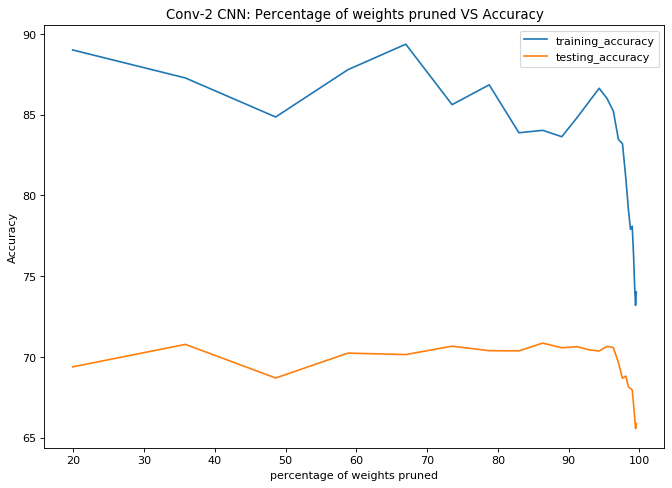

In [58]:
# Visualization of training and testing accuracy VS percentage of weights
# pruned-
fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_accuracy.keys()), list(plot_accuracy.values()), label = 'training_accuracy')
plt.plot(list(plot_test_accuracy.keys()), list(plot_test_accuracy.values()), label = 'testing_accuracy')

plt.title("Conv-2 CNN: Percentage of weights pruned VS Accuracy")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()

In [59]:
# Python 3 dict for training and testing loss visualization-
plot_loss = {}
plot_test_loss = {}

In [60]:
# populate 'plot_loss'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['loss'][epoch_length - 1]


In [61]:
# populate 'plot_test_loss'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_test_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_loss'][epoch_length - 1]


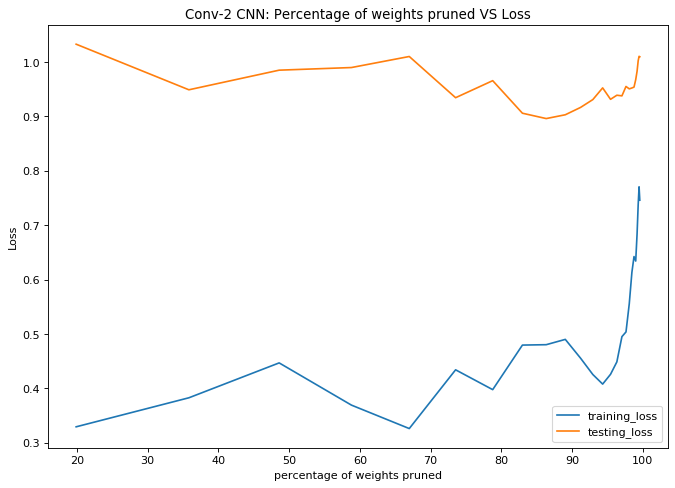

In [62]:
# Visualization of training and testing loss VS percentage of remaining weights-
# pruned-
fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_loss.keys()), list(plot_loss.values()), label = 'training_loss')
plt.plot(list(plot_test_loss.keys()), list(plot_test_loss.values()), label = 'testing_loss')

plt.title("Conv-2 CNN: Percentage of weights pruned VS Loss")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

In [63]:
# Plot number of epochs (Early Stopping) VS percentage of weights pruned-

# Python 3 dict to hold number of epochs vs % of weights pruned-
plot_num_epochs = {}
plot_num_epochs_test = {}


In [64]:
# populate 'plot_num_epochs'-
for k in history_main.keys():
    num_epochs = len(history_main[k]['accuracy'])
    plot_num_epochs[history_main[k]['percentage_wts_pruned']] = num_epochs


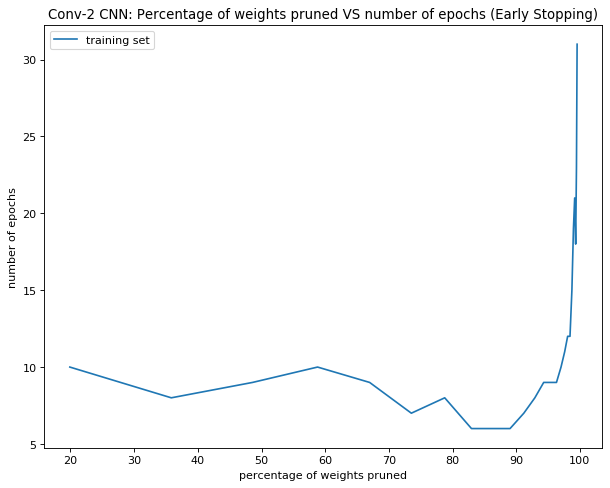

In [65]:
# Visualize percentage of weights remaining VS number of epochs (Early Stopping)
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_num_epochs.keys()), list(plot_num_epochs.values()), label = 'training set')
# plt.plot(list(plot_num_epochs_test.keys()), list(plot_num_epochs_test.values()), label = 'testing set')

plt.title("Conv-2 CNN: Percentage of weights pruned VS number of epochs (Early Stopping)")
plt.xlabel("percentage of weights pruned")
plt.ylabel("number of epochs")
plt.legend(loc = 'best')
plt.show()


In [66]:
# Try to visualize the STARTING training and testing accuracy VS percentage
# of remaining weights-

# Python 3 dict for visualization-
plot_starting_accuracy = {}
plot_starting_test_accuracy = {}

# Key:    percentage of weights pruned
# Value:  starting accuracy


In [67]:
# populate 'plot_starting_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['accuracy'][0]


In [68]:
# populate 'plot_starting_test_accuracy'-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_test_accuracy[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_accuracy'][0]


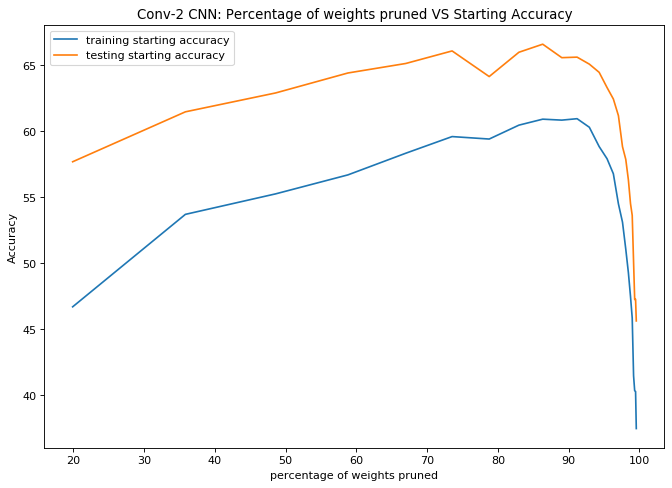

In [69]:
# Visualize starting accuracy VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_starting_accuracy.keys()), list(plot_starting_accuracy.values()), label = 'training starting accuracy')
plt.plot(list(plot_starting_test_accuracy.keys()), list(plot_starting_test_accuracy.values()), label = 'testing starting accuracy')

plt.title("Conv-2 CNN: Percentage of weights pruned VS Starting Accuracy")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()


In [70]:
# Try to visualize the STARTING training and testing loss VS percentage
# of remaining weights-

# Python 3 dict for visualization-
plot_starting_loss = {}
plot_starting_test_loss = {}

# Key:		percentage of weights pruned
# Value:	starting loss


In [71]:
# Populate 'plot_starting_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['loss'][0]


In [72]:
# Populate 'plot_starting_test_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_starting_test_loss[history_main[k]['percentage_wts_pruned']] = history_main[k]['val_loss'][0]


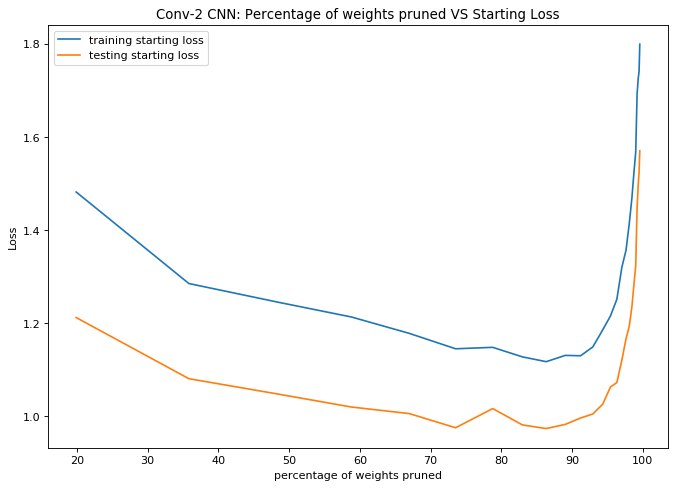

In [73]:
# Visualize Starting training & testing loss VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_starting_loss.keys()), list(plot_starting_loss.values()), label = 'training starting loss')
plt.plot(list(plot_starting_test_loss.keys()), list(plot_starting_test_loss.values()), label = 'testing starting loss')

plt.title("Conv-2 CNN: Percentage of weights pruned VS Starting Loss")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

In [74]:
# Try to visualize: percentage of weights remaining VS BEST accuracy within each iterative
# pruning round

# Python 3 dict for visualization-
plot_best_accuracy = {}
plot_best_test_accuracy = {}

# Key:		percentage of weights pruned
# Value:	best accuracy

In [75]:
# Populate 'plot_best_accuracy' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_best_accuracy[history_main[k]['percentage_wts_pruned']] = np.amax(history_main[k]['accuracy'])


In [76]:
# Populate 'plot_best_test_accuracy' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['accuracy'])
    plot_best_test_accuracy[history_main[k]['percentage_wts_pruned']] = np.amax(history_main[k]['val_accuracy'])


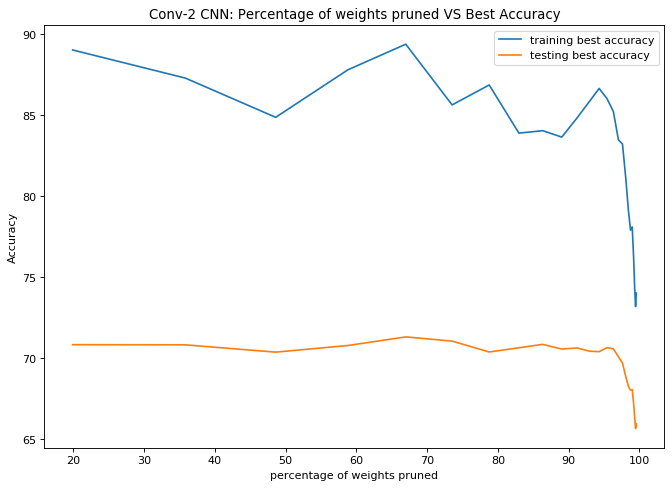

In [77]:
# Visualize best accuracy VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_best_accuracy.keys()), list(plot_best_accuracy.values()), label = 'training best accuracy')
plt.plot(list(plot_best_test_accuracy.keys()), list(plot_best_test_accuracy.values()), label = 'testing best accuracy')

plt.title("Conv-2 CNN: Percentage of weights pruned VS Best Accuracy")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()


In [78]:
# Try to visualize: percentage of weights remaining VS LOWEST loss within each iterative
# pruning round

# Python 3 dict for visualization-
plot_best_loss = {}
plot_best_test_loss = {}

# Key:		percentage of weights pruned
# Value:	best loss

In [79]:
# Populate 'plot_best_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_best_loss[history_main[k]['percentage_wts_pruned']] = np.amin(history_main[k]['loss'])


In [80]:
# Populate 'plot_best_test_loss' Python 3 dict-
for k in history_main.keys():
    epoch_length = len(history_main[k]['loss'])
    plot_best_test_loss[history_main[k]['percentage_wts_pruned']] = np.amin(history_main[k]['val_loss'])


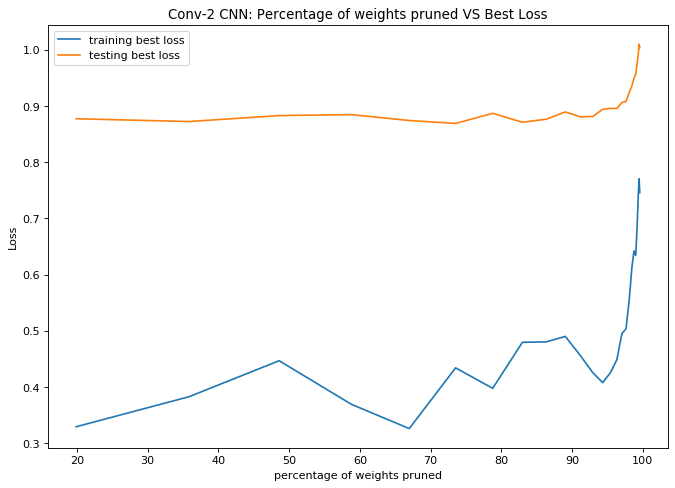

In [81]:
# Visualize best loss VS percentage of weights pruned-
fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(list(plot_best_loss.keys()), list(plot_best_loss.values()), label = 'training best loss')
plt.plot(list(plot_best_test_loss.keys()), list(plot_best_test_loss.values()), label = 'testing best loss')

plt.title("Conv-2 CNN: Percentage of weights pruned VS Best Loss")
plt.xlabel("percentage of weights pruned")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()


### Find the winning ticket(s):

In [82]:
for k in history_main.keys():
	epoch_length = len(history_main[k]['loss'])

	if k == 1:
		print("epoch: {0}, val_acc = {1:.4f}% with {2:.4f}% weights pruned, needs = {3} epochs".format(
			k, history_main[k]['val_accuracy'][epoch_length-1],
			0, epoch_length))
	else:
		print("epoch: {0}, val_acc = {1:.4f}% with {2:.4f}% weights pruned, needs = {3} epochs".format(
			k, history_main[k]['val_accuracy'][epoch_length-1],
			history_main[k - 1]['percentage_wts_pruned'], epoch_length))


epoch: 1, val_acc = 69.3900% with 0.0000% weights pruned, needs = 10 epochs
epoch: 2, val_acc = 70.7800% with 19.9013% weights pruned, needs = 8 epochs
epoch: 3, val_acc = 68.7000% with 35.8322% weights pruned, needs = 9 epochs
epoch: 4, val_acc = 70.2400% with 48.5876% weights pruned, needs = 10 epochs
epoch: 5, val_acc = 70.1500% with 58.7990% weights pruned, needs = 9 epochs
epoch: 6, val_acc = 70.6700% with 66.9747% weights pruned, needs = 7 epochs
epoch: 7, val_acc = 70.3900% with 73.5217% weights pruned, needs = 8 epochs
epoch: 8, val_acc = 70.3800% with 78.7637% weights pruned, needs = 6 epochs
epoch: 9, val_acc = 70.8600% with 82.9639% weights pruned, needs = 6 epochs
epoch: 10, val_acc = 70.5700% with 86.3275% weights pruned, needs = 6 epochs
epoch: 11, val_acc = 70.6400% with 89.0235% weights pruned, needs = 7 epochs
epoch: 12, val_acc = 70.4400% with 91.1831% weights pruned, needs = 8 epochs
epoch: 13, val_acc = 70.3700% with 92.9144% weights pruned, needs = 9 epochs
epoch: 